# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'

dataset_train_1 = pd.read_csv(drive_path+'Dataset_Train_1_new.csv')
dataset_test_1 = pd.read_csv(drive_path+'Dataset_Test_1_new.csv')

dataset_train_1.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


## Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

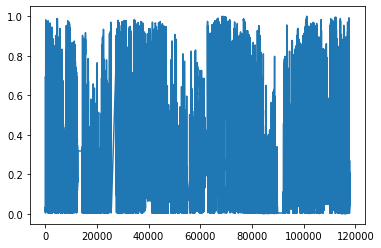

In [ ]:
# Full set
training_set = dataset_train_1['Park_Power_[KW]']
test_set = dataset_test_1['Park_Power_[KW]']

#This weird transformation is only to use the same array structure the original code was already using
training_set = training_set.values
test_set = test_set.values
full_set = np.concatenate((training_set,test_set))
training_set = np.transpose([np.transpose(training_set)])
test_set = np.transpose([np.transpose(test_set)])
full_set = np.transpose([np.transpose(full_set)])

plt.plot(training_set, label = 'Park_Power_[KW]')
plt.show()

## Dataloading

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

#sc = MinMaxScaler() #This isn't necessary as data is already normalized
#training_data = sc.fit_transform(training_set)

seq_length = 4

x, y = sliding_windows(training_set, seq_length)
trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))

#x, y = sliding_windows(test_set, seq_length)
#testX = Variable(torch.Tensor(np.array(x)))
#testY = Variable(torch.Tensor(np.array(y)))

#x, y = sliding_windows(full_set, seq_length)
#dataX = Variable(torch.Tensor(np.array(x)))
#dataY = Variable(torch.Tensor(np.array(y)))

## Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06102
Epoch: 100, loss: 0.00277
Epoch: 200, loss: 0.00149
Epoch: 300, loss: 0.00114
Epoch: 400, loss: 0.00103
Epoch: 500, loss: 0.00099
Epoch: 600, loss: 0.00099
Epoch: 700, loss: 0.00099
Epoch: 800, loss: 0.00099
Epoch: 900, loss: 0.00098
Epoch: 1000, loss: 0.00098
Epoch: 1100, loss: 0.00098
Epoch: 1200, loss: 0.00098
Epoch: 1300, loss: 0.00098
Epoch: 1400, loss: 0.00098
Epoch: 1500, loss: 0.00098
Epoch: 1600, loss: 0.00098
Epoch: 1700, loss: 0.00098
Epoch: 1800, loss: 0.00098
Epoch: 1900, loss: 0.00098


## Testing for Park Power values

In [ ]:
pred_testX = []

# Predicting first values of the test data with last values of train data
# Each iteration predicts exactly 1 value and adds it to the pred_testX array
# When items for train data cannot be fed into the LSTM, items from pred_testX are used, one by one

window_test_set = np.vstack((training_set[len(training_set)-seq_length:len(training_set)],[[0],[0]]))
x, y = sliding_windows(window_test_set, seq_length)
dataX = Variable(torch.Tensor(np.array(x)))

lstm.eval()
test_predict = lstm(dataX)
data_predict = test_predict.data.numpy()
pred_testX.append(data_predict[0])

for i in range(1,seq_length):
  window_test_set = np.vstack((training_set[len(training_set)-seq_length+i:len(training_set)],pred_testX,[[0],[0]]))
  x, y = sliding_windows(window_test_set, seq_length)
  dataX = Variable(torch.Tensor(np.array(x)))

  lstm.eval()
  test_predict = lstm(dataX)
  data_predict = test_predict.data.numpy()
  pred_testX.append(data_predict[0])

# Predicting rest of the 96 values exclusively with predicted data from pred_testX
for i in range(96-seq_length):
  window_test_set = np.vstack((pred_testX[len(pred_testX)-seq_length:len(pred_testX)],[[0],[0]]))
  x, y = sliding_windows(window_test_set, seq_length)
  dataX = Variable(torch.Tensor(np.array(x)))

  lstm.eval()
  test_predict = lstm(dataX)
  data_predict = test_predict.data.numpy()
  pred_testX.append(data_predict[0])

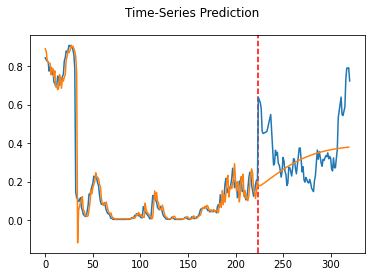

In [ ]:
# Plotting last train values with test values vs predicted values

lstm.eval()
train_predict = lstm(trainX)

train_predict = train_predict.data.numpy()

dataY_plot = np.vstack((training_set[len(training_set)-224:],test_set[0:97]))
data_predict = np.vstack((train_predict[len(train_predict)-224:],pred_testX))

plt.axvline(x=len(training_set[len(training_set)-224:]), c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()